Motion estimation by using mean of motion vectors.

Step 1: Calculate optical flow of each video.

Step 2: Convert these optical flow vectors into histogram of optical flow (HOF).

Step 3: These HOF vectors are features of videos. Use the HOF for classification.

Extracting HOF features from videos...
Processing 9 videos in class 'bend'...
  Processed daria_bend.avi, extracted HOF feature of length 40
  Processed denis_bend.avi, extracted HOF feature of length 40
  Processed eli_bend.avi, extracted HOF feature of length 40
  Processed ido_bend.avi, extracted HOF feature of length 40
  Processed ira_bend.avi, extracted HOF feature of length 40
  Processed lena_bend.avi, extracted HOF feature of length 40
  Processed lyova_bend.avi, extracted HOF feature of length 40
  Processed moshe_bend.avi, extracted HOF feature of length 40
  Processed shahar_bend.avi, extracted HOF feature of length 40
Processing 9 videos in class 'jack'...
  Processed daria_jack.avi, extracted HOF feature of length 40
  Processed denis_jack.avi, extracted HOF feature of length 40
  Processed eli_jack.avi, extracted HOF feature of length 40
  Processed ido_jack.avi, extracted HOF feature of length 40
  Processed ira_jack.avi, extracted HOF feature of length 40
  Processed l

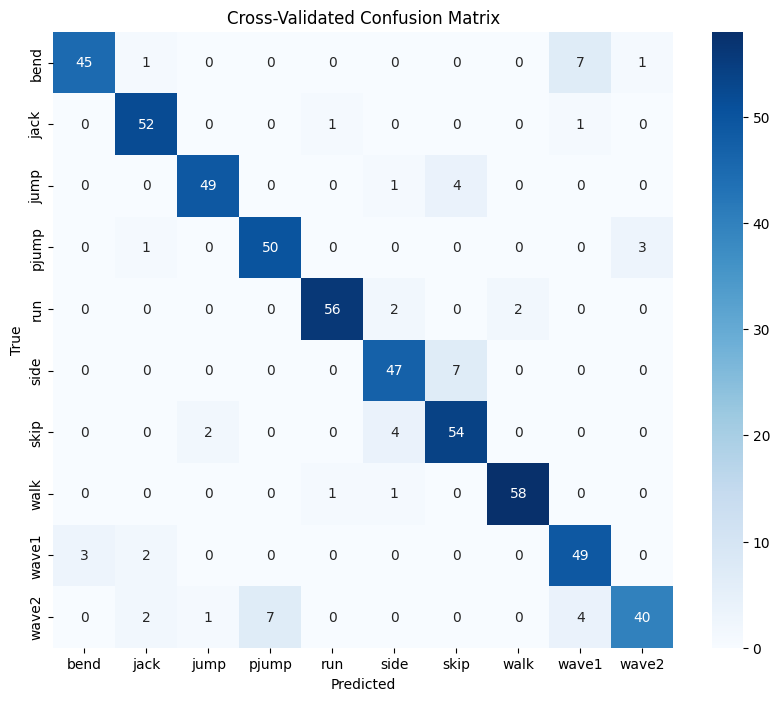


Classification Report:
              precision    recall  f1-score   support

        bend       0.94      0.83      0.88        54
        jack       0.90      0.96      0.93        54
        jump       0.94      0.91      0.92        54
       pjump       0.88      0.93      0.90        54
         run       0.97      0.93      0.95        60
        side       0.85      0.87      0.86        54
        skip       0.83      0.90      0.86        60
        walk       0.97      0.97      0.97        60
       wave1       0.80      0.91      0.85        54
       wave2       0.91      0.74      0.82        54

    accuracy                           0.90       558
   macro avg       0.90      0.89      0.89       558
weighted avg       0.90      0.90      0.90       558

Weighted F1-Score: 0.8957

Training complete. Model trained with best parameters:
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [28]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

def calculate_optical_flow(file_path):

    cap = cv.VideoCapture(file_path)

     # Check if the video opened successfully
    if not cap.isOpened():
        print(f"Error: Could not open video file: {file_path}")
        return None

    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 100,
                        qualityLevel = 0.3,
                        minDistance = 7,
                        blockSize = 7 )
    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15, 15),
                    maxLevel = 2,
                    criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
    
    # Create some random colors
    color = np.random.randint(0, 255, (100, 3))

    # Take first frame and find corners in it
    ret, old_frame = cap.read()
    old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
    p0 = cv.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)

    motion_vectors = []


    while(cap.isOpened()):
        ret, frame = cap.read()

        if not ret:
            break

        frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        # Select good points
        if p1 is not None:
            good_new = p1[st==1]
            good_old = p0[st==1]

            # Calculate and store motion vectors
            if len(good_new) > 0:
                # Calculate displacement for each point
                displacements = good_new - good_old
                mean_displacement = np.mean(displacements, axis=0)
                motion_vectors.append(mean_displacement)

            # Update the previous frame and points
            old_gray = frame_gray.copy()
            p0 = good_new.reshape(-1, 1, 2)
        else:
            break

    # Clean up
    cap.release()
    
    # Return the motion vectors data
    return np.array(motion_vectors) if motion_vectors else None

def calculate_hof(motion_vectors, num_bins=128):
    if motion_vectors is None or len(motion_vectors) == 0:
        return None
        
    # Initialize histogram bins (covering 0 to 360 degrees)
    histogram = np.zeros(num_bins, dtype=np.float32)
    
    # Calculate magnitude and angle for each motion vector
    for vector in motion_vectors:
        dx, dy = vector
        
        # Calculate magnitude and angle (in degrees)
        magnitude = np.sqrt(dx**2 + dy**2)
        angle = np.degrees(np.arctan2(dy, dx)) % 360
        
        # Determine which bin this angle belongs to
        bin_idx = int(angle / (360 / num_bins))
        
        # Add the magnitude to the corresponding bin
        # Using magnitude as weight gives more importance to stronger motions
        histogram[bin_idx] += magnitude
    
    # Normalize the histogram (L1 normalization)
    if np.sum(histogram) > 0:
        histogram = histogram / np.sum(histogram)
    
    return histogram

def process_video_directory(root_dir):
    features = []
    labels = []
    
    # Check if directory exists
    if not os.path.exists(root_dir):
        print(f"Error: Directory {root_dir} does not exist")
        return features, labels
    
    # Find all class directories (run, jump, walk)
    class_dirs = [d for d in os.listdir(root_dir) 
                  if os.path.isdir(os.path.join(root_dir, d))]
    
    for class_dir in class_dirs:
        class_path = os.path.join(root_dir, class_dir)
        video_files = [f for f in os.listdir(class_path) 
                       if f.endswith(('.mp4', '.avi', '.mov'))]
        
        print(f"Processing {len(video_files)} videos in class '{class_dir}'...")
        
        for video_file in video_files:
            video_path = os.path.join(class_path, video_file)
            
            # Extract motion vectors using optical flow
            motion_vectors = calculate_optical_flow(video_path)
            
            if motion_vectors is not None and len(motion_vectors) > 0:
                # Convert motion vectors to HOF feature
                hof_feature = calculate_hof(motion_vectors, num_bins=40)  # Reduced bins for better generalization
                
                if hof_feature is not None:
                    features.append(hof_feature)
                    labels.append(class_dir)
                    print(f"  Processed {video_file}, extracted HOF feature of length {len(hof_feature)}")
            else:
                print(f"  Could not extract motion vectors from {video_file}")
    
    return features, labels

def augment_features(features, labels, noise_level=0.05, num_augmentations=3):
    aug_features = []
    aug_labels = []
    
    features = np.array(features)
    
    # Add original samples
    aug_features.extend(features)
    aug_labels.extend(labels)
    
    print(f"Adding {num_augmentations} augmented samples per video...")
    
    # Add noise-augmented samples
    for i in range(len(features)):
        for _ in range(num_augmentations):
            # Add random Gaussian noise
            noise = np.random.normal(0, noise_level, size=features[i].shape)
            
            # Ensure the resulting feature is still a valid probability distribution
            augmented = features[i] + noise
            
            # Ensure non-negative values and re-normalize if needed
            augmented = np.maximum(0, augmented)
            if np.sum(augmented) > 0:
                augmented = augmented / np.sum(augmented)
                
            aug_features.append(augmented)
            aug_labels.append(labels[i])
    
    return aug_features, aug_labels

def train_and_evaluate_model(features, labels):
    # Augment the features to increase dataset size
    aug_features, aug_labels = augment_features(features, labels, 
                                               noise_level=0.03,
                                               num_augmentations=5)
    
    # Convert to numpy arrays
    X = np.array(aug_features)
    y = np.array(aug_labels)
    
    print(f"Training with {len(X)} samples ({len(features)} original + {len(X)-len(features)} augmented)")
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Define parameter grid for GridSearch
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.01, 0.1],
        'kernel': ['rbf', 'linear']
    }
    
    # Define cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize SVM model
    base_model = SVC(class_weight='balanced', probability=True)
    
    # Initialize GridSearchCV
    print("Starting GridSearch for optimal parameters...")
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=cv,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )
    
    # Perform grid search
    grid_search.fit(X_scaled, y)
    
    # Print best parameters and score
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best F1 score: {grid_search.best_score_:.4f}")
    
    # Get predictions using cross-validation with the best model
    y_pred = np.zeros_like(y, dtype=object)
    for train_idx, test_idx in cv.split(X_scaled, y):
        model = SVC(**grid_search.best_params_, class_weight='balanced')
        model.fit(X_scaled[train_idx], y[train_idx])
        y_pred[test_idx] = model.predict(X_scaled[test_idx])
    
    # Plot confusion matrix
    class_names = np.unique(y)
    cm = confusion_matrix(y, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Cross-Validated Confusion Matrix')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y, y_pred))
    
    # Calculate F1-score
    f1 = f1_score(y, y_pred, average='weighted')
    print(f"Weighted F1-Score: {f1:.4f}")
    
    # Train final model on all data with best parameters
    final_model = SVC(**grid_search.best_params_, class_weight='balanced')
    final_model.fit(X_scaled, y)
    
    return final_model, grid_search.best_params_

def main():
    # Directory containing class subdirectories with videos
    video_dir = "./resources"
    
    print("Extracting HOF features from videos...")
    features, labels = process_video_directory(video_dir)
    
    if len(features) == 0:
        print("No features were extracted. Check your video files and paths.")
        return
    
    print(f"Extracted {len(features)} HOF feature vectors across {len(set(labels))} classes.")
    
    # Train and evaluate model
    model, best_params = train_and_evaluate_model(features, labels)
    
    print("\nTraining complete. Model trained with best parameters:")
    print(best_params)

if __name__ == "__main__":
    main()